In [1]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt

In [3]:
N = 1000
radius = 0.7

In [4]:
X = np.random.uniform(low=-1, high=1, size=(N,2))
Y = np.sum(X**2, axis=1)**0.5 >= radius

In [5]:
X_test = np.random.uniform(low=-1, high=1, size=(N,2))
Y_test = np.sum(X_test**2, axis=1)**0.5 >= radius

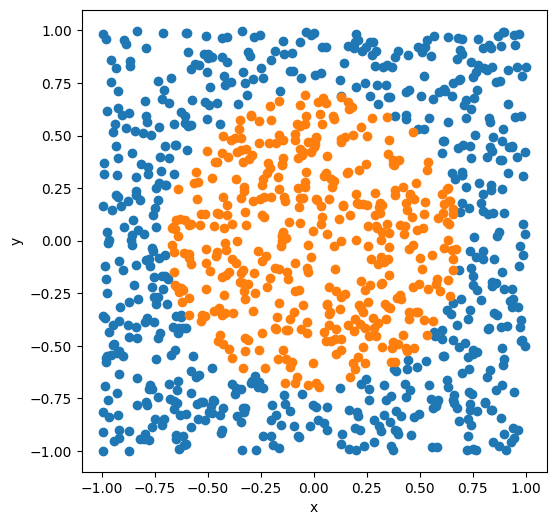

In [6]:
plt.figure(figsize=(6,6))
plt.scatter(X[:,0][Y == True], X[:,1][Y == True])
plt.scatter(X[:,0][Y == False], X[:,1][Y == False])
plt.xlabel("x")
plt.ylabel("y");

In [7]:
x_train = X
y_train = 2*Y - 1

x_test = X_test
y_test = 2*Y_test - 1

In [8]:
dev = qml.device('lightning.qubit', wires=1)

In [9]:
def layer(data, params):
    phi = data*params[:3] + params[3:6]
    qml.Rot(phi[0], phi[1], phi[2], wires=0)

In [10]:
layers = 10
@qml.qnode(dev)
def classifier(data, params):
    for i in range(layers):
        layer(data, params[i*6:(i+1)*6])
    return qml.expval(qml.PauliZ(0))

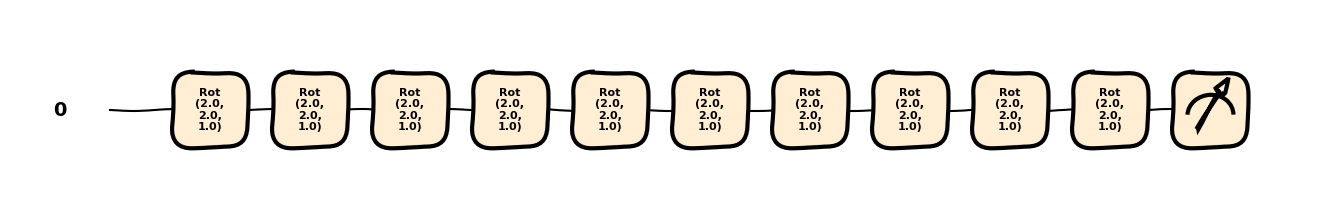

In [11]:
qml.draw_mpl(classifier, decimals=1, style="sketch")([1,1,0],np.ones(layers*6))
plt.show()

In [12]:
def loss(batch_x, batch_y, params):
  loss = 0
  for idx, x in enumerate(batch_x):
    y_pred = classifier(np.pad(x, (0,1)),params)
    loss += np.maximum(1 - batch_y[idx] * y_pred, 0)
  return loss / len(batch_x)

In [13]:
params = np.array(np.random.uniform(size=6*layers), requires_grad=True)*np.pi

In [14]:
def iterate_minibatches(dataX, dataY, batch_size):
    for start_idx in range(0, dataX.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield dataX[idxs], dataY[idxs]

In [15]:
def accuracy(dataX, dataY, params):
  acc = 0
  for idx, x in enumerate(dataX):
    pred = -1 if classifier(np.pad(x, (0,1)), params) < 0 else 1
    if pred == dataY[idx]: acc += 1
  return acc / len(dataX)

In [16]:
epochs = 6
batch_size = 16
lr = 0.05

In [17]:
opt = qml.AdamOptimizer(stepsize=lr)

In [18]:
import time
start = time.time()

for it in range(epochs):
    for j,data in enumerate(iterate_minibatches(x_train, y_train, batch_size=batch_size)):
        Xbatch, Ybatch = data
        cost_fn = lambda p: loss(Xbatch, Ybatch, p)
        params = opt.step(cost_fn, params)
        print(j, end="\r")

    loss_val = loss(x_train, y_train, params)
    acc = accuracy(x_train, y_train, params)

    print(f"Epoch: {it} | Loss: {loss_val:.3} | acc: {acc:.3} ")
    print("____")

end = time.time()

print(f"Time for {epochs} epochs: {end - start}")

Epoch: 0 | Loss: 0.436 | acc: 0.853 
____
Epoch: 1 | Loss: 0.369 | acc: 0.899 
____
Epoch: 2 | Loss: 0.285 | acc: 0.943 
____
Epoch: 3 | Loss: 0.278 | acc: 0.946 
____
Epoch: 4 | Loss: 0.272 | acc: 0.944 
____
Epoch: 5 | Loss: 0.268 | acc: 0.942 
____
Time for 6 epochs: 713.4722511768341


In [ ]:
plt.figure(figsize=(6,6))
class0 = x_test[np.array([classifier(np.pad(i, (0,1)),params) for i in x_test]) < 0]
class1 = x_test[np.array([classifier(np.pad(i, (0,1)),params) for i in x_test]) > 0]
plt.scatter(class0[:,0], class0[:,1])
plt.scatter(class1[:,0], class1[:,1])
circle1 = plt.Circle((0, 0), radius, color='r', fill=False, linewidth=5)
plt.gca().add_patch(circle1)